In [14]:
import pandas as pd
from math import radians, sin, cos, sqrt, atan2
import networkx as nx
import matplotlib.pyplot as plt

#### Funções para o cálculo de distância entre uma estação e outra no DataFrame

In [15]:
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371.0 * 1000

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return round(distance, 2)


def get_station_info(station_name, df):
    station_rows = df[df["Station"] == station_name]
    if not station_rows.empty:
        station_info = {
            "Latitude": station_rows.iloc[0]["Latitude"],
            "Longitude": station_rows.iloc[0]["Longitude"],
            "Lines": set(station_rows["Line"]),
        }
        return station_info
    else:
        return None


def calculate_distance(row, df):
    origin_info = get_station_info(row["Station"], df)
    dest_info = get_station_info(row["Destination"], df)

    if origin_info and dest_info:
        if origin_info["Lines"].intersection(dest_info["Lines"]):
            return haversine_distance(
                origin_info["Latitude"],
                origin_info["Longitude"],
                dest_info["Latitude"],
                dest_info["Longitude"],
            )
    return None

#### Formatações do Dataframe

In [16]:
df = pd.read_csv("Metro_Madrid_2021.csv")
df = df.drop("Traffic", axis=1)
df["Longitude"] = df["Longitude"].str.replace(",", ".").astype(float)
df["Latitude"] = df["Latitude"].str.replace(",", ".").astype(float)
df.insert(1, "Destination", df["Station"].shift(-1))
df.insert(2, "Distance", df.apply(lambda row: calculate_distance(row, df), axis=1))  # noqa: F821
df = df.dropna(subset=["Distance"])
df.drop(df.loc[df["Distance"] > 5000].index, inplace=True)
new_rows = df.copy()
new_rows.rename(
    columns={"Station": "Destination", "Destination": "Station"}, inplace=True
)
df = pd.concat([df, new_rows], ignore_index=True)

In [17]:
df.head()

,Station,Destination,Distance,Line,Order of Points,Longitude,Latitude
0,Pinar de Chamartin,Bambú,867.28,Linea 1,1,-3.667061,40.480136
1,Bambú,Chamartín,754.71,Linea 1,2,-3.676374,40.476872
2,Chamartín,Plaza de Castilla,799.03,Linea 1,3,-3.682768,40.472138
3,Plaza de Castilla,Valdeacederas,573.41,Linea 1,4,-3.689163,40.466849
4,Valdeacederas,Tetuán,422.98,Linea 1,5,-3.695128,40.464401


#### Criação do grafo

In [18]:
graph_df = df[["Station", "Destination", "Distance"]]
graph_df = graph_df.dropna()

In [19]:
graph = {}
#Colocando todos dos dados do DataFrame em um Dict
for row in df.itertuples():
    station = row.Station
    destination = row.Destination
    distance = row.Distance

    if pd.isna(distance):
        continue

    if station not in graph:
        graph[station] = []

    graph[station].append((destination, distance))

## Depth First Search (profundidade)

In [20]:
def dfs(graph, station, destination, visited, path, nodes_explored):
    if visited == []:
        visited = []
    if path == []:
        path = [station] # Estação origem é a primeira do caminho a ser percorrido

    visited.append(station)

    # Incrementar o contador de nós abertos
    nodes_explored += 1

    # Verificação do nó objetivo
    if station == destination:
        return path, nodes_explored

    # Verificando os nós vizinhos
    adjacents = [adjacent for adjacent, distance in graph.get(station, [])]
    for adjacent in adjacents:
        if adjacent not in visited:
            # Recursão enviando nó vizinho para a função
            new_path, nodes_explored = dfs(
                graph, adjacent, destination, visited, path + [adjacent], nodes_explored
            )
            if new_path:  # Verificação de um caminho válido
                return new_path, nodes_explored

    return None, nodes_explored  # Se nenhum caminho foi encontrado

In [27]:
start = "Bambú"
end = "Santiago Bernabéu"
nodes_explored = 0

path, nodes_explored = dfs(graph, start, end, [], [], nodes_explored)

print("Caminho encontrado:", path)
print("Número total de nós explorados:", nodes_explored)

Caminho encontrado: ['Bambú', 'Chamartín', 'Plaza de Castilla', 'Valdeacederas', 'Tetuán', 'Estrecho', 'Alvarado', 'Cuatro Caminos', 'Ríos Rosas', 'Iglesia', 'Bilbao', 'Tribunal', 'Gran Vía', 'Sol', 'Tirso de Molina', 'Antón Martín', 'Estación del Arte', 'Atocha', 'Menéndez Pelayo', 'Pacífico', 'Méndez Álvaro', 'Arganzuela-Planetario', 'Legazpi', 'Usera', 'Plaza Elíptica', 'Opañel', 'Oporto', 'Urgel', 'Marqués de Vadillo', 'Pirámides', 'Acacias', 'Puerta de Toledo', 'La Latina', 'Ópera', 'Santo Domingo', 'Noviciado', 'San Bernardo', 'Quevedo', 'Canal', 'Alonso Cano', 'Gregorio Marañón', 'Avenida de América', 'Prosperidad', 'Alfonso XIII', 'Avenida de la Paz', 'Arturo Soria', 'Esperanza', 'Canillas', 'Mar de Cristal', 'Pinar del Rey', 'Colombia', 'Nuevos Ministerios', 'Santiago Bernabéu']
Número total de nós explorados: 137


#### Função para o cálculo da distância total percorrida

In [28]:
def total_distance(graph_df, path, start):
    distance = 0
    for i in path[1:]:
        distance += graph_df[(graph_df["Station"] == start) & (graph_df["Destination"] == i)]["Distance"].iloc[0]
        start = i
    return round(distance,2)

In [29]:
distance = total_distance(graph_df, path, start)
print(distance)

37169.47


#### Função para a vizualização do grafo

In [30]:
def visualize_graph(graph_dict, df, path=None):
    # Criando o grafo a partir do dicionário
    G = nx.Graph()
    for station, adjacents in graph_dict.items():
        for destination, distance in adjacents:
            G.add_edge(station, destination, weight=distance)

    # Adicionando posições ao grafo
    pos = {
        row["Station"]: (row["Longitude"], row["Latitude"])
        for idx, row in df.iterrows()
    }

    plt.figure(figsize=(20, 15))

    # Desenha os nós e arestas com estilo básico
    nx.draw(G, pos, node_size=50, node_color="blue", edge_color="gray", alpha=0.5)

    # Desenha o caminho com um estilo diferente, se existir
    if path:
        path_edges = list(zip(path, path[1:]))
        nx.draw_networkx_nodes(G, pos, nodelist=path, node_size=100, node_color="red")
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color="red", width=2)
        # Cria rótulos apenas para os nós do caminho
        labels = {node: node for node in path}
        nx.draw_networkx_labels(G, pos, labels=labels, font_size=5)

    plt.title("Mapa do Metrô de Madrid com DFS")
    plt.axis("off")
    plt.show()

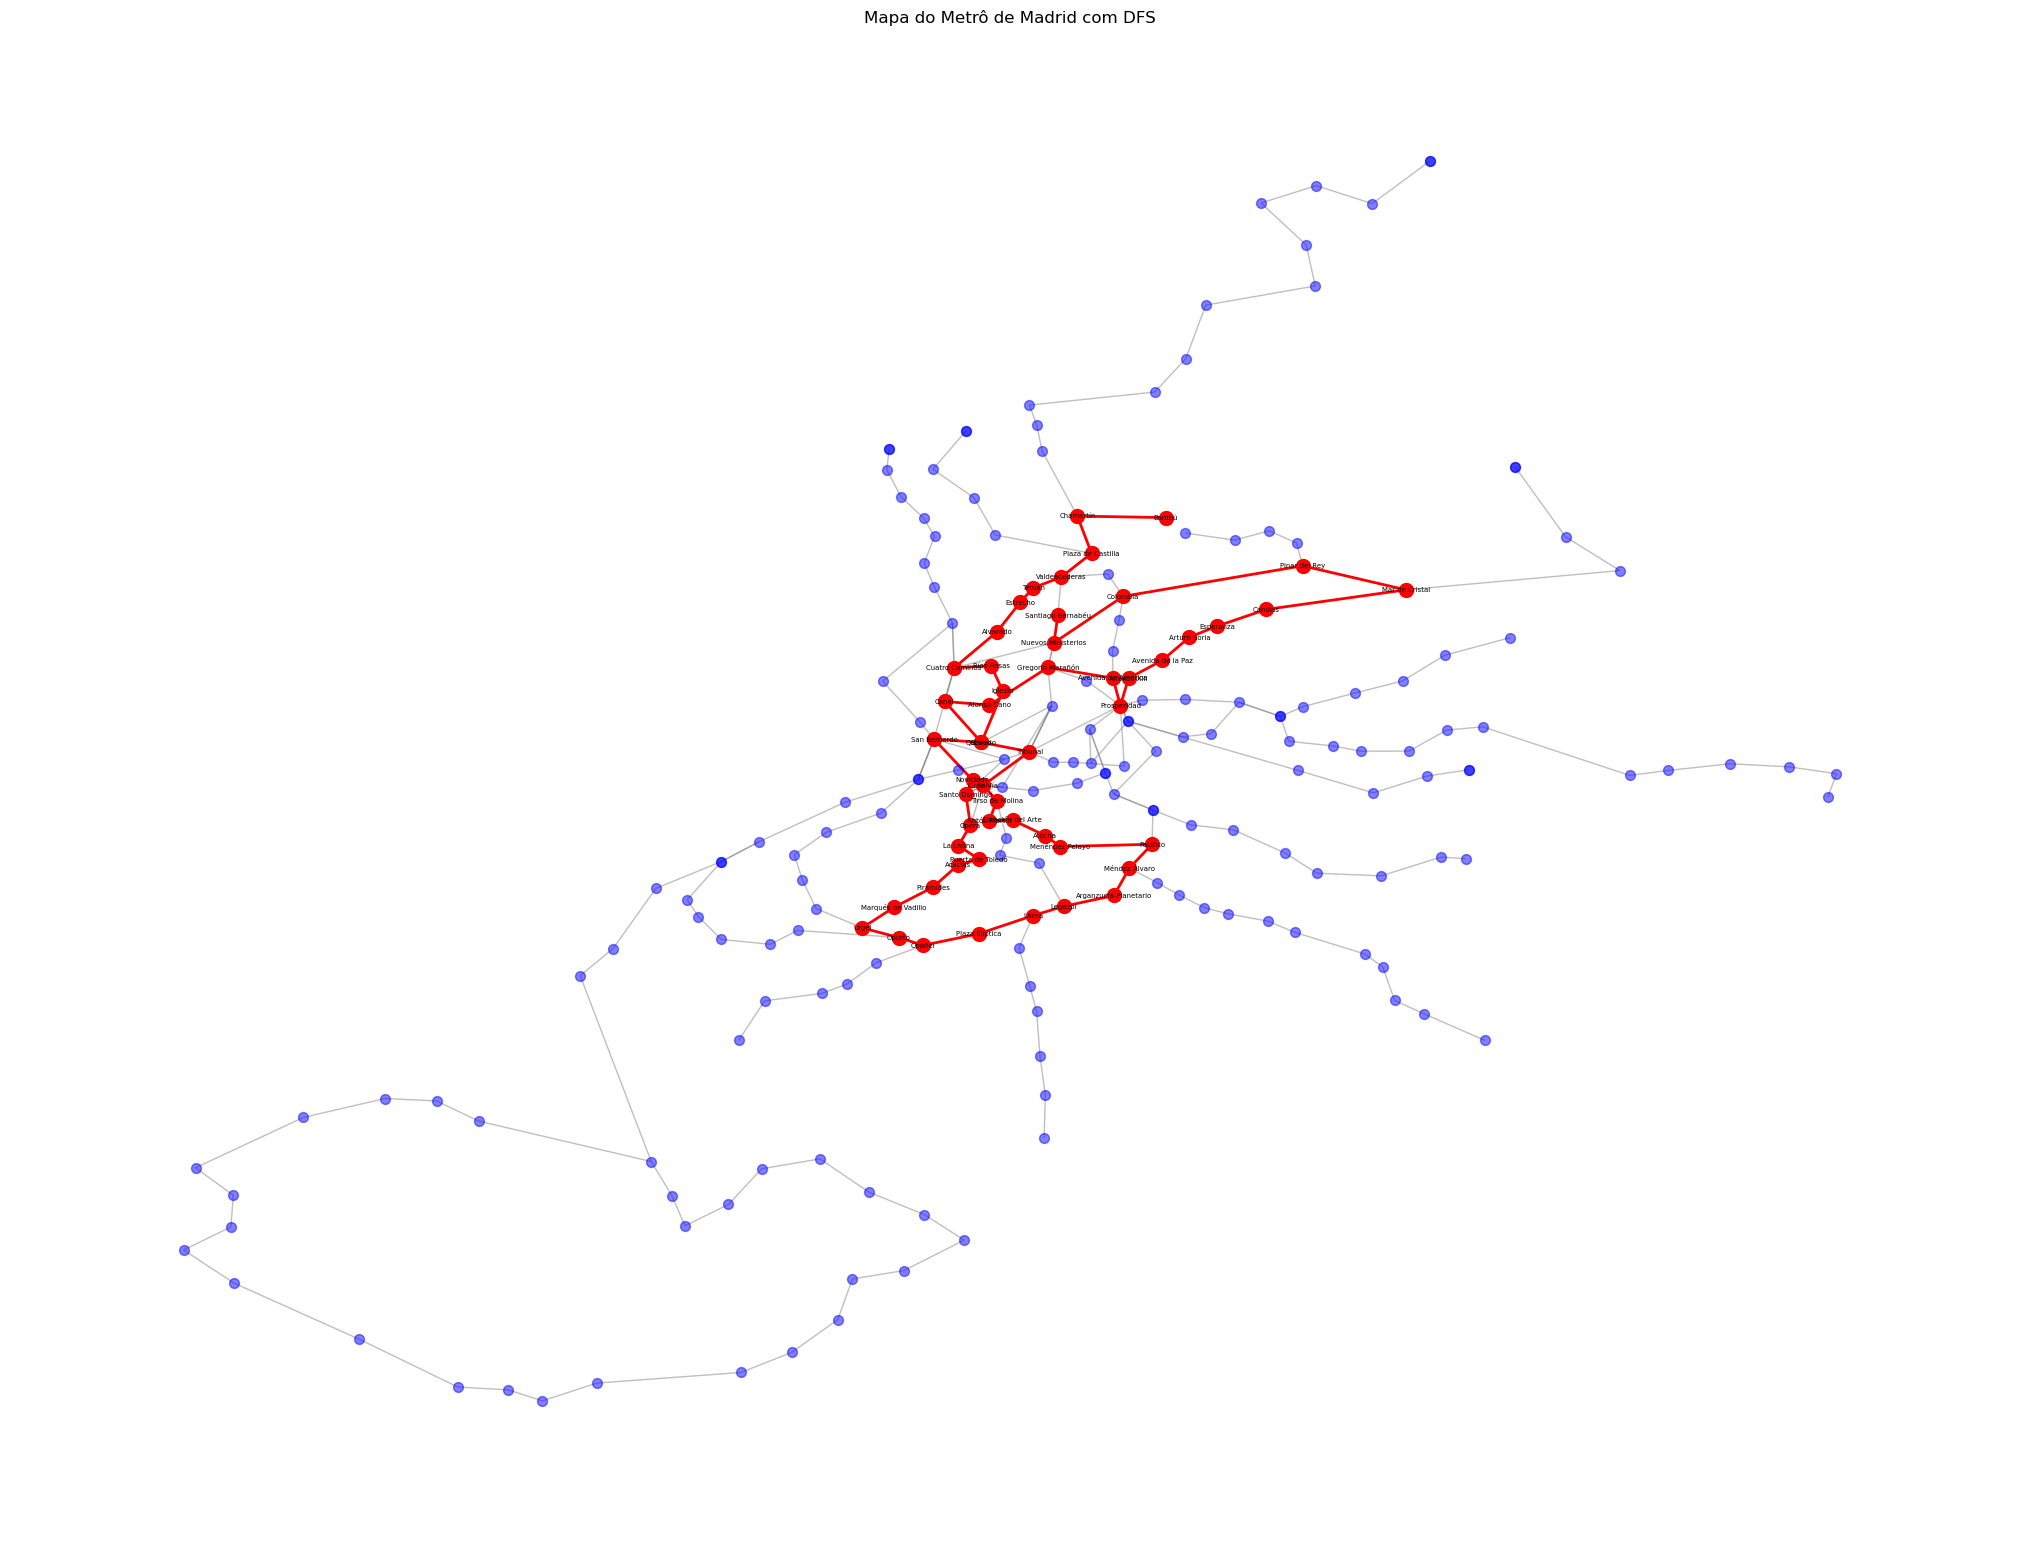

In [31]:
visualize_graph(graph, df, path)